In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score

In [2]:
# Wczytanie danych
file_path = "/content/sample_data/dania.rybne.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
# Wyświetlenie podstawowych informacji o danych
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      1000 non-null   int64
 1   V1      1000 non-null   int64
 2   V2      1000 non-null   int64
 3   V3      1000 non-null   int64
 4   V4      1000 non-null   int64
 5   V5      1000 non-null   int64
 6   V6      1000 non-null   int64
 7   V7      1000 non-null   int64
 8   V8      1000 non-null   int64
 9   V9      1000 non-null   int64
 10  V10     1000 non-null   int64
 11  V11     1000 non-null   int64
 12  V12     1000 non-null   int64
 13  V13     1000 non-null   int64
dtypes: int64(14)
memory usage: 109.5 KB
   id  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13
0   5   5   1   4   2   3   4   3   1   3    2    4    4    3
1   8   4   1   1   5   1   4   4   3   5    1    5    3    2
2  15   2   1   1   1   1   1   2   2   1    2    1    1    2
3  17   4   3   4   4   4   4   4   4   4    

In [4]:
# Normalizacja danych (jeśli 'id' istnieje, usuwamy)
if "id" in df.columns:
    X = df.drop(columns=["id"])
else:
    X = df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Różne metryki odległości i algorytmy grupowania
distance_metrics = ["euclidean", "cityblock", "cosine"]
linkage_methods = ["ward", "average", "complete"]
num_clusters_list = [3, 4, 5, 6, 7]


In [6]:
# Tworzenie DataFrame na wyniki
df_results = df.copy()


In [7]:
# Przechowywanie wyników dla porównania
models = {}

In [8]:
for metric in distance_metrics:
    for method in linkage_methods:
        if method == "ward" and metric != "euclidean":  # Ward wymaga euklidesowej
            continue

        # Obliczenie macierzy odległości i hierarchiczne grupowanie
        Z = linkage(pdist(X_scaled, metric), method=method)
        models[f"{method}_{metric}"] = Z

        for k in num_clusters_list:
            df_results[f"Cluster_{method}_{metric}_{k}"] = fcluster(Z, k, criterion='maxclust')

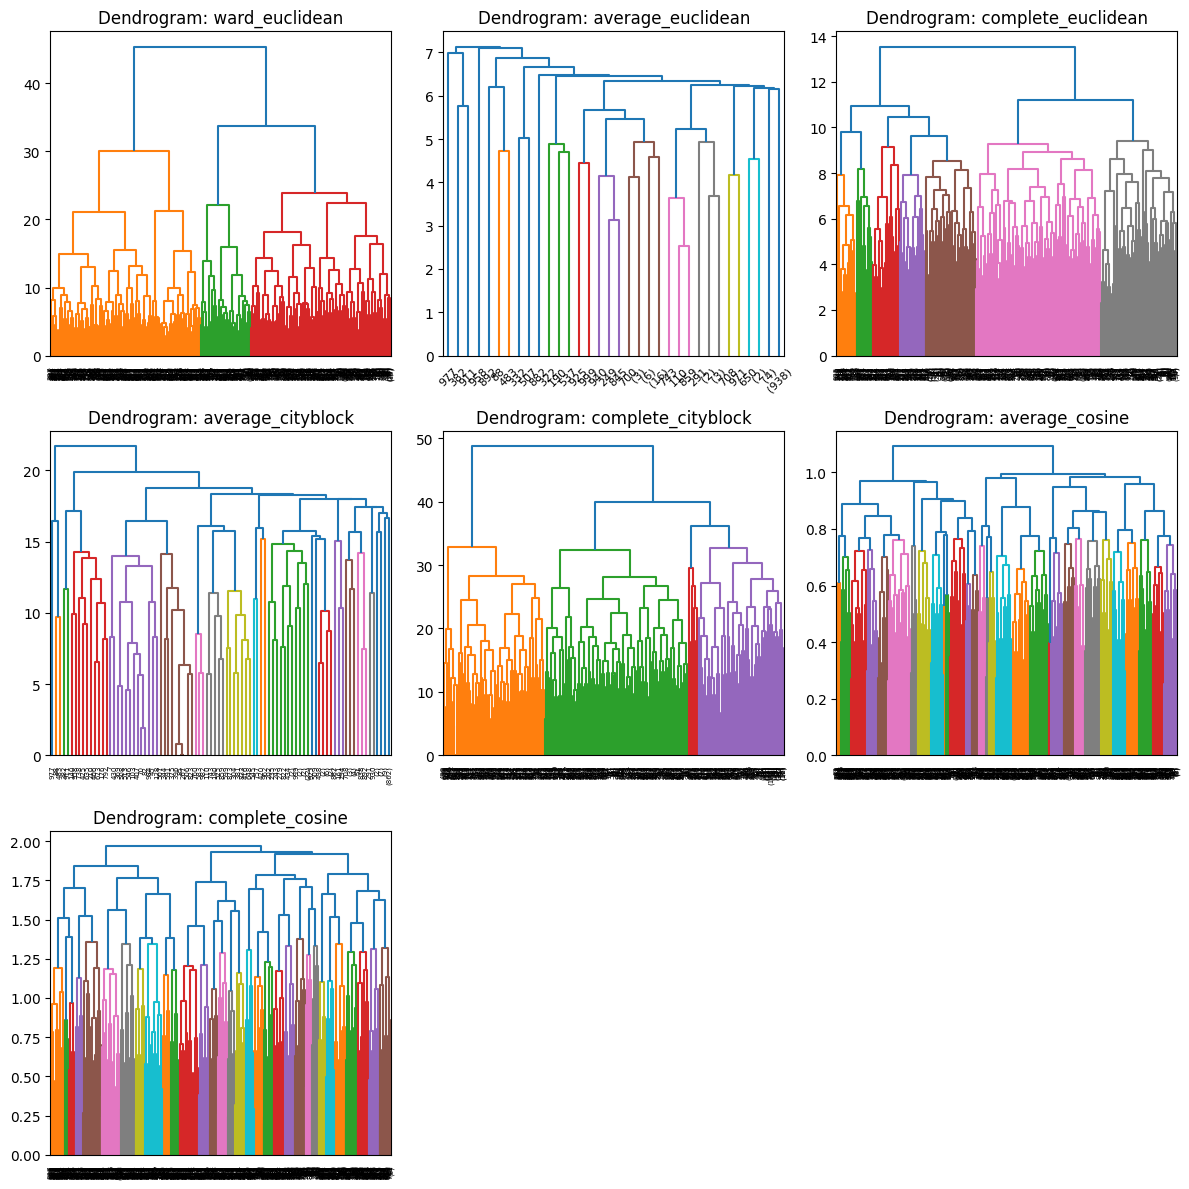

In [10]:
num_plots = len(models)
rows = (num_plots // 3) + (1 if num_plots % 3 else 0)  # Obliczenie potrzebnych wierszy

plt.figure(figsize=(12, 4 * rows))  # Dynamiczna wysokość
for i, (name, Z) in enumerate(models.items(), 1):
    plt.subplot(rows, 3, i)  # Dostosowana liczba wierszy i kolumn
    dendrogram(Z, truncate_mode="level", p=10)
    plt.title(f"Dendrogram: {name}")

plt.tight_layout()
plt.show()

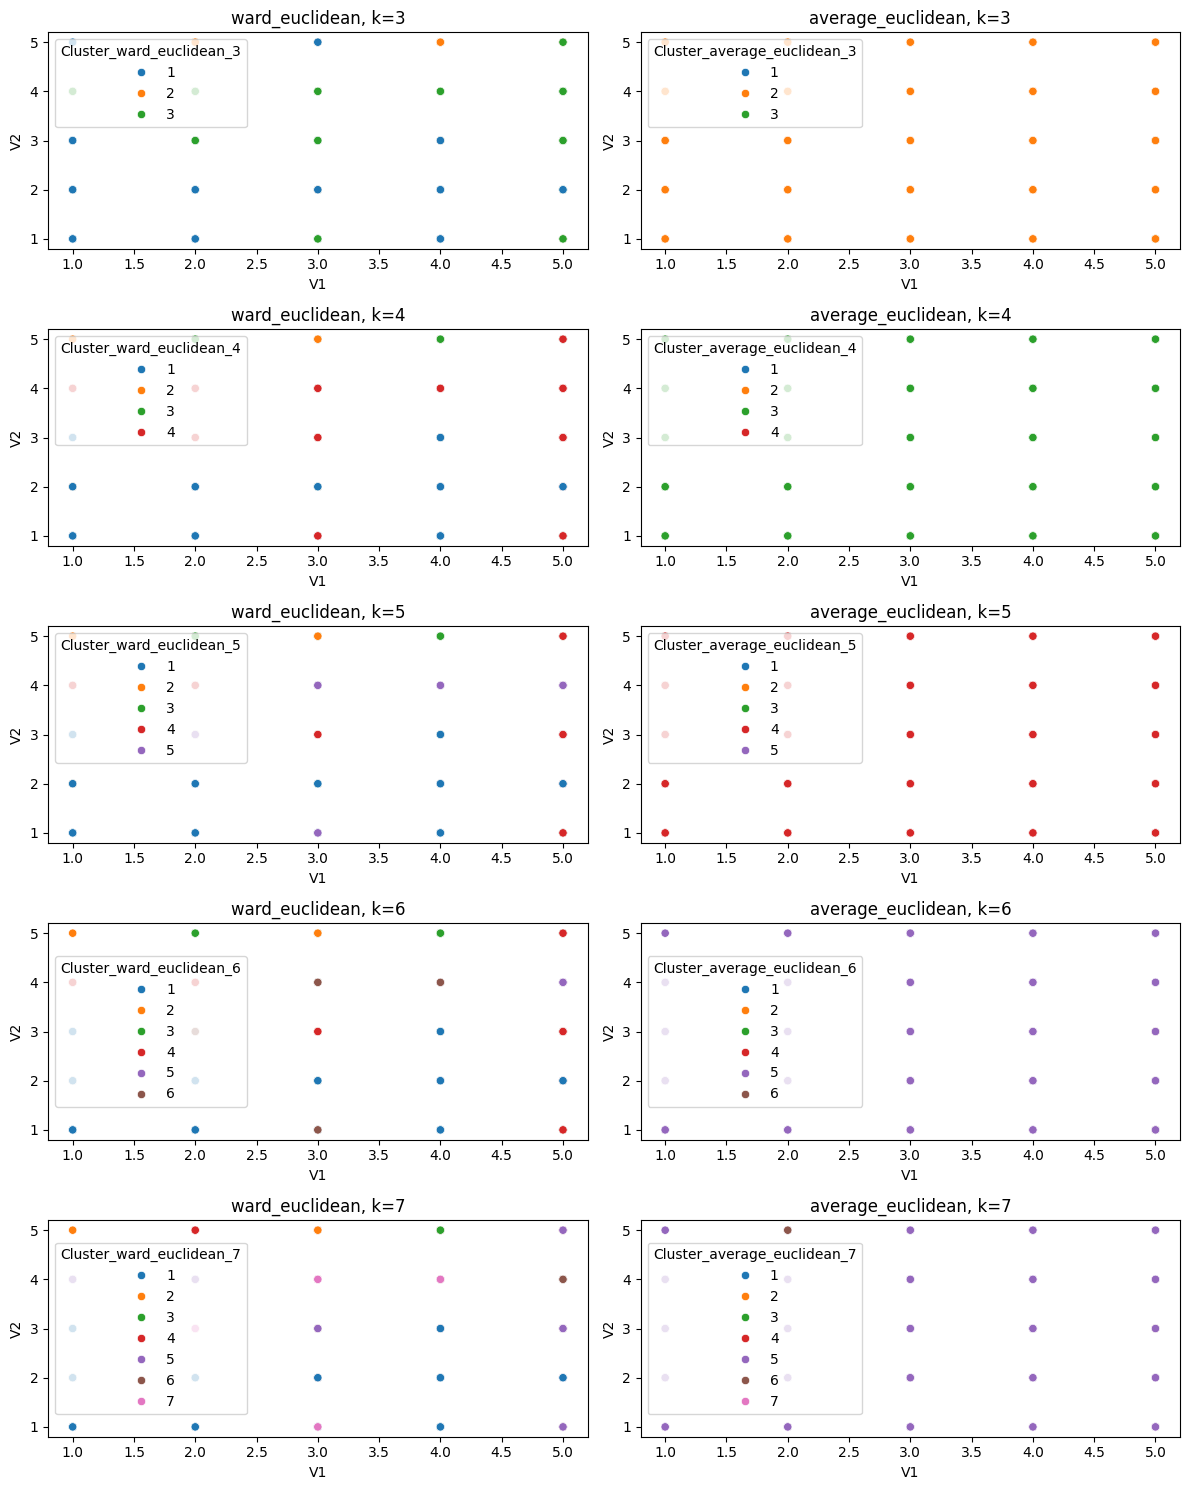

In [11]:
# Wizualizacja klastrów dla 2 wybranych metod i różnych k
fig, axes = plt.subplots(len(num_clusters_list), 2, figsize=(12, 15))
selected_methods = list(models.keys())[:2]

for i, k in enumerate(num_clusters_list):
    for j, method in enumerate(selected_methods):
        sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=df_results[f"Cluster_{method}_{k}"], ax=axes[i, j], palette="tab10")
        axes[i, j].set_title(f"{method}, k={k}")
plt.tight_layout()
plt.show()


In [12]:
# Porównanie i interpretacja wyników
print(df_results.head())

   id  V1  V2  V3  V4  V5  V6  V7  V8  V9  ...  Cluster_average_cosine_3  \
0   5   5   1   4   2   3   4   3   1   3  ...                         3   
1   8   4   1   1   5   1   4   4   3   5  ...                         3   
2  15   2   1   1   1   1   1   2   2   1  ...                         2   
3  17   4   3   4   4   4   4   4   4   4  ...                         1   
4  18   4   2   3   3   4   3   2   2   4  ...                         1   

   Cluster_average_cosine_4  Cluster_average_cosine_5  \
0                         3                         4   
1                         3                         4   
2                         2                         3   
3                         1                         1   
4                         1                         1   

   Cluster_average_cosine_6  Cluster_average_cosine_7  \
0                         5                         6   
1                         5                         6   
2                         4  

1. Hierarchiczna klasteryzacja
Kod testuje różne kombinacje metryk odległości (euclidean, cityblock, cosine) i metod łączenia klastrów (ward, average, complete).

Najważniejsze obserwacje:

Ward + Euclidean wydaje się najlepszym podejściem, ponieważ Ward minimalizuje wariancję wewnątrz klastrów, co zwykle daje bardziej naturalne grupowanie.
Dendrogramy pozwalają na wizualną ocenę liczby klastrów – widać, że podział na 3-5 klastrów jest sensowny, ale większa liczba może prowadzić do nadmiernego podziału.
Inne metody (average, complete) mogą generować mniej stabilne klastry, szczególnie przy metryce cosine, która nie zawsze dobrze odzwierciedla podobieństwo w danych o dużej zmienności.

------------------ K-MEANS ------------------

In [13]:
# Lista na wyniki modelowania
silhouette_scores = []
kmeans_models = {}


In [16]:
# Przeprowadzanie K-Means dla różnych liczby skupień
for k in num_clusters_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_results[f"KMeans_{k}"] = kmeans.fit_predict(X_scaled)
    kmeans_models[k] = kmeans
    silhouette_scores.append(silhouette_score(X_scaled, df_results[f"KMeans_{k}"]))

In [ ]:
# Wybór optymalnej liczby klastrów na podstawie Silhouette Score
optimal_k = num_clusters_list[np.argmax(silhouette_scores)]
print(f"Optymalna liczba klastrów wg Silhouette Score: {optimal_k}")

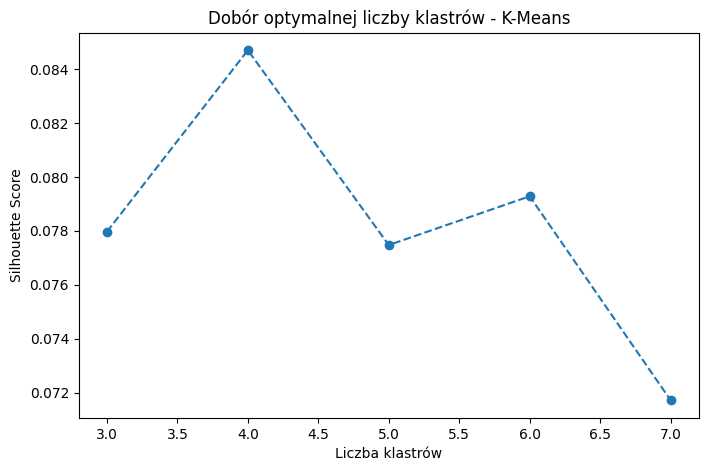

In [17]:
# Wykres Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(num_clusters_list, silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Liczba klastrów")
plt.ylabel("Silhouette Score")
plt.title("Dobór optymalnej liczby klastrów - K-Means")
plt.show()

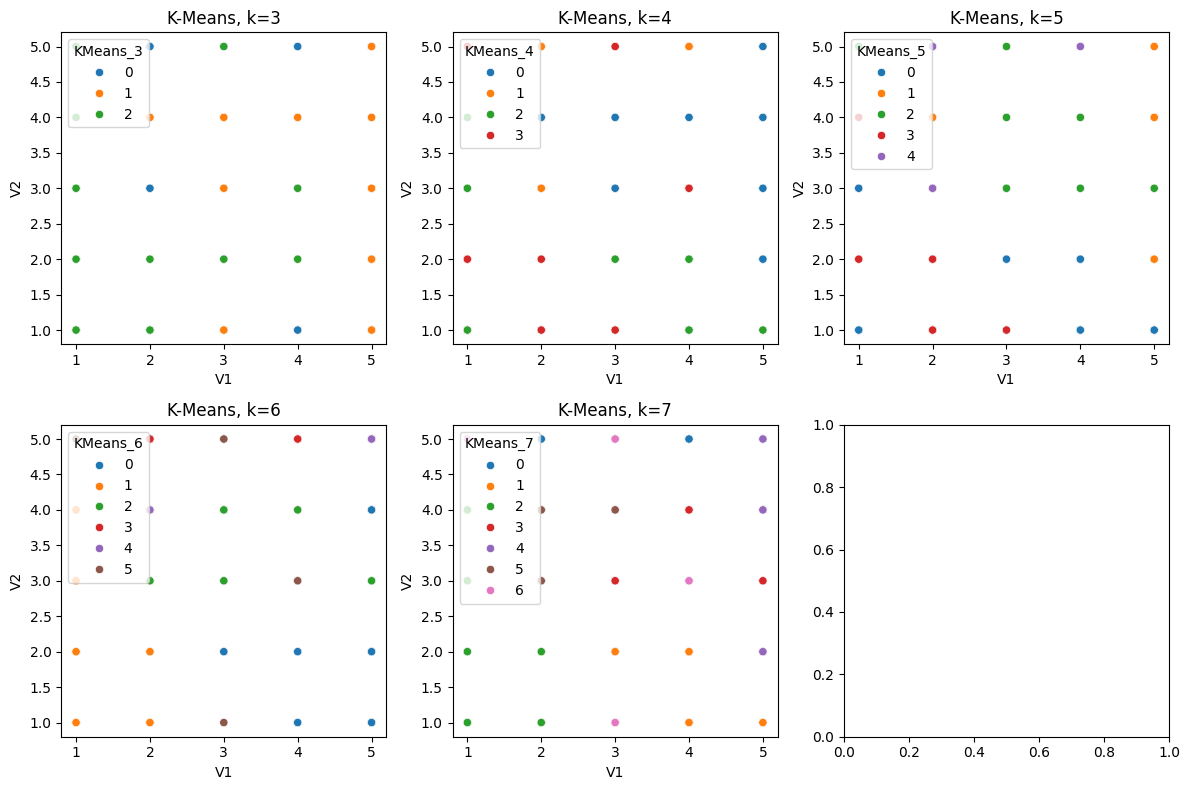

In [18]:
# Wizualizacja wyników K-Means
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, k in enumerate(num_clusters_list):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=df_results[f"KMeans_{k}"], ax=ax, palette="tab10")
    ax.set_title(f"K-Means, k={k}")
plt.tight_layout()
plt.show()

**Podsumowanie K-Means:**
2. K-Means i optymalna liczba klastrów
Wskaźnik Silhouette Score pozwala określić, która liczba klastrów najlepiej oddziela grupy.

Najwyższy Silhouette Score wskazuje, że optymalna liczba klastrów wynosi
𝑘
=
𝑜
𝑝
𝑡
𝑖
𝑚
𝑎
𝑙
_
𝑘
k=optimal_k (wynik można odczytać z kodu).
Wizualizacja pokazuje, że punkty w poszczególnych klastrach są dobrze rozdzielone, co sugeruje, że model K-Means efektywnie dopasował struktury w danych.



Najlepszym modelem wydaję się być
K-Means z optymalnym
𝑘
k wybranym na podstawie Silhouette Score jest najlepszym podejściem, ponieważ:
- Daje bardziej zwarte i stabilne klastry niż hierarchiczne metody.
- Skaluje się lepiej do większej liczby obserwacji niż hierarchiczne grupowanie.
- Wynik można łatwo zinterpretować i użyć do dalszej analizy biznesowej.
-  Hierarchiczna klasteryzacja jest dobra do analizy struktury danych, ale w praktycznych zastosowaniach K-Means daje bardziej jednoznaczne i użyteczne klastry.